# Identifying SRKW Orca Calls using CNN and SNN
## 02-Use CNN to identify SRKW calls

In [1]:
%matplotlib inline

Import libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import glob
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

import tensorflow as tf
import keras.backend as K

from keras_preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.models import  Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, BatchNormalization, Concatenate
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling2D
from keras.applications import DenseNet121

Define directories

In [3]:
parentdir="../"
codedir=parentdir+"code/"
datadir=parentdir+"data/"
train_dir=datadir+"TrainDataLatest_PodCastAllRounds_123567910/"
test_dir=datadir+"TestDataLatest_PodCastAllRounds_123/"
output=parentdir+"output/"
specdir=output+"spectrogram/"
specdir_train=specdir+"train/all/"
specdir_test=specdir+"test/all/"

In [4]:
directory_filenames_train_pos = glob.glob(specdir_train + '*_pos.png')
directory_filenames_train_neg = glob.glob(specdir_train + '*_neg.png')
directory_filenames_test_pos = glob.glob(specdir_test + '*_pos.png')
directory_filenames_test_neg = glob.glob(specdir_test + '*_neg.png')

In [5]:
f=os.path.join(train_dir,'annotations.tsv')
anno_table=pd.read_csv(f, sep='\t')
del(f)

f=os.path.join(test_dir,'test.tsv')
test_table=pd.read_csv(f, sep='\t')
del(f)

 Read in spectrograms

In [6]:
spectrogram_pos=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_train_pos)):
    img=cv2.imread(directory_filenames_train_pos[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spectrogram_pos.append(img)
spectrogram_pos=np.asarray(spectrogram_pos, dtype=object)
del(i, img)

Check the errors list. If the list is not empty, regenerate those samples.

In [7]:
for i in errors:
    print(i, directory_filenames_train_pos[i])

In [8]:
spectrogram_neg=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_train_neg)):
    img=cv2.imread(directory_filenames_train_neg[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spectrogram_neg.append(img)
spectrogram_neg=np.asarray(spectrogram_neg, dtype=object)
del(i, img)

In [9]:
for i in errors:
    print(i, directory_filenames_train_neg[i])

In [10]:
index_pos=list(range(len(directory_filenames_train_pos)))
index_neg=list(range(len(directory_filenames_train_neg)))
listpos=np.full((len(directory_filenames_train_pos),1), 1.0)
listneg=np.full((len(directory_filenames_train_neg),1), 0.0)

In [11]:
# Split up the training data into 80% train and 20% validation. 
# There is a set aside testing data that we will not use in the training.  
X_pos_train, X_pos_validation, y_pos_train, y_pos_validation, index_pos_train, index_pos_validation = train_test_split(spectrogram_pos, listpos, index_pos, test_size=0.2, random_state=76)
X_neg_train, X_neg_validation, y_neg_train, y_neg_validation, index_neg_train, index_neg_validation = train_test_split(spectrogram_neg, listneg, index_neg, test_size=0.2, random_state=76)

 Mix up the positive and negative smaple again in the train and validation cohorts

In [12]:
x_train=np.concatenate([X_pos_train, X_neg_train])
y_train=np.concatenate([y_pos_train, y_neg_train])
x_validation=np.concatenate([X_pos_validation, X_neg_validation])
y_validation=np.concatenate([y_pos_validation, y_neg_validation])
print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)

(4329, 224, 224, 3)
(4329, 1)
(1084, 224, 224, 3)
(1084, 1)


Creating a set testing data following similar steps as above

In [13]:
spect_test_pos=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_test_pos)):
    img=cv2.imread(directory_filenames_test_pos[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spect_test_pos.append(img)
spect_test_pos=np.asarray(spect_test_pos, dtype=object)
del(i, img)

In [14]:
for i in errors:
    print(i, directory_filenames_test_pos[i])

In [15]:
spect_test_neg=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_test_neg)):
    img=cv2.imread(directory_filenames_test_neg[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spect_test_neg.append(img)
spect_test_neg=np.asarray(spect_test_neg, dtype=object)
del(i, img)

In [16]:
for i in errors:
    print(i, directory_filenames_test_neg[i])

In [17]:
index_test_pos=list(range(len(directory_filenames_test_pos)))
index_test_neg=list(range(len(directory_filenames_test_neg)))
listtestpos=np.full((len(directory_filenames_test_pos),1), 1.0)
listtestneg=np.full((len(directory_filenames_test_neg),1), 0.0)

In [18]:
x_test=np.concatenate([spect_test_pos, spect_test_neg])
y_test=np.concatenate([listtestpos, listtestneg])
print(x_test.shape)
print(y_test.shape)

(809, 224, 224, 3)
(809, 1)


In [19]:
number_of_classes = y_train.shape[1]
print(number_of_classes)
DenseNet121_conv = DenseNet121(weights='imagenet', include_top=False, input_shape=(nrow, ncol, 3))

1


In [ ]:
for layer in DenseNet121_conv.layers:
    layer.trainable = True

for layer in DenseNet121_conv.layers:
    print(layer, layer.trainable)

In [21]:
model = models.Sequential()
model.add(DenseNet121_conv)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(number_of_classes, activation='sigmoid'))
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer = optimizer, metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5

In [22]:
x_train=x_train.astype('float32')
y_train=y_train.astype('float32')
x_validation=x_validation.astype('float32')
y_validation=y_validation.astype('float32')
x_test=x_test.astype('float32')
y_test=y_test.astype('float32')

In [23]:
model_history = model.fit(x_train, y_train, batch_size=16, epochs=5, verbose=1, validation_data=(x_validation, y_validation))
y_train_pred_prob = model.predict(x_train)

Epoch 1/5
271/271 [==============================] - 4192s 15s/step - loss: 3.2502 - accuracy: 0.8977 - val_loss: 0.4596 - val_accuracy: 0.8312
Epoch 2/5
271/271 [==============================] - 4000s 15s/step - loss: 0.8676 - accuracy: 0.9402 - val_loss: 14056.7637 - val_accuracy: 0.8976
Epoch 3/5
271/271 [==============================] - 4024s 15s/step - loss: 2.7438 - accuracy: 0.9307 - val_loss: 465.2297 - val_accuracy: 0.9105
Epoch 4/5
271/271 [==============================] - 4013s 15s/step - loss: 0.5259 - accuracy: 0.9598 - val_loss: 5.2207 - val_accuracy: 0.9788
Epoch 5/5
136/136 [==============================] - 830s 6s/step


Text(0.5, 1.0, 'Predicted Probability of All Training Samples')

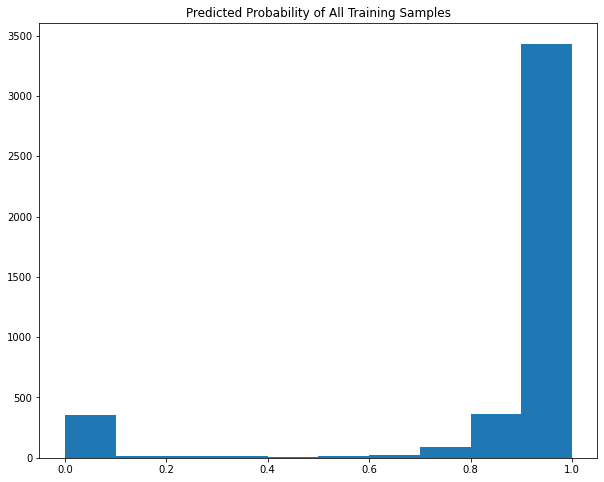

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(y_train_pred_prob[:,0])
ax.set_title('Predicted Probability of All Training Samples')

Prediction for labeled calls (Positive)

In [25]:
yhat_probs_Positive = model.predict(spectrogram_pos.astype('float32'))

152/152 [==============================] - 967s 6s/step


Text(0.5, 1.0, 'Predicted Probability of Positive Calls')

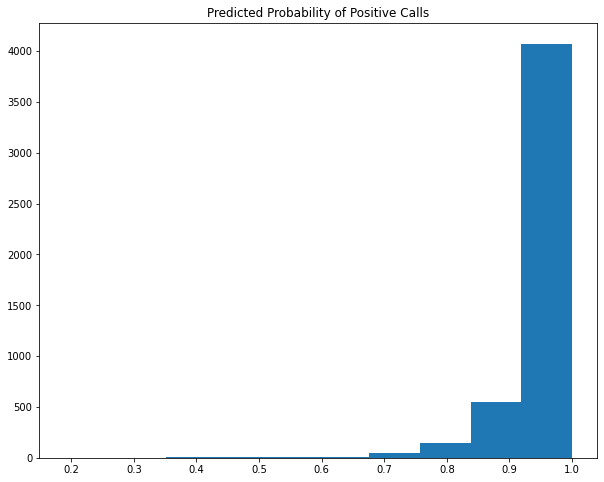

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_Positive[:,0])
ax.set_title('Predicted Probability of Positive Calls')

In [27]:
tp_train=len([i for i in yhat_probs_Positive if i>=0.5])
fn_train=len([i for i in yhat_probs_Positive if i<0.5])
fnr_train=(fn_train)/(tp_train+fn_train)
print('False Negative Rate on the training data:', '{:.2%}'.format(fnr_train))

False Negative Rate on the training data: 0.23%


Prediction for no calls (Negative)

In [28]:
yhat_probs_Negative = model.predict(spectrogram_neg.astype('float32'))

19/19 [==============================] - 109s 6s/step


Text(0.5, 1.0, 'Predicted Probability of Negative Calls')

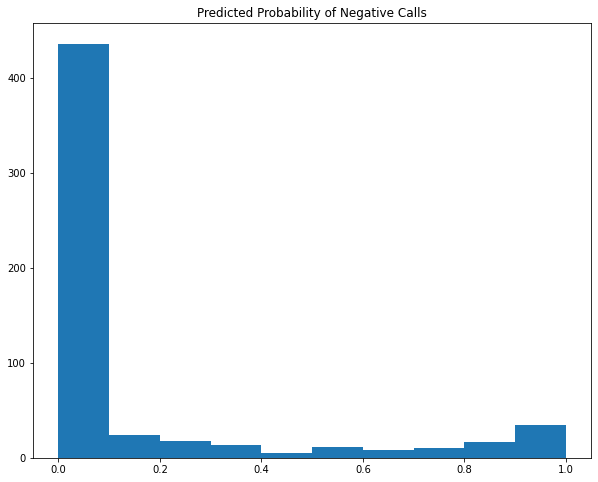

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_Negative[:,0])
ax.set_title('Predicted Probability of Negative Calls')

In [30]:
tn_train=len([i for i in yhat_probs_Negative if i<0.5])
fp_train=len([i for i in yhat_probs_Negative if i>=0.5])
fpr_train=(fp_train)/(tn_train+fp_train)
print('False Positive Rate on the training data:', '{:.2%}'.format(fpr_train))

False Positive Rate on the training data: 14.04%


In [31]:
precision_train = tp_train / (tp_train + fp_train)
recall_train = tp_train / (tp_train + fn_train)
accuracy_train = (tp_train + tn_train) / (tp_train + fp_train + tn_train + fn_train)
print('Training Accuracy: %.4f' % accuracy_train)
print('Training Precision: %.4f' % precision_train)
print('Training Recall: %.4f' % recall_train)

Training Accuracy: 0.9830
Training Precision: 0.9835
Training Recall: 0.9977


Model Evalutaion

In [32]:
yhat_probs_test = model.predict(x_test.astype('float32'))

26/26 [==============================] - 144s 6s/step


Text(0.5, 1.0, 'Predicted Probability of Testing data')

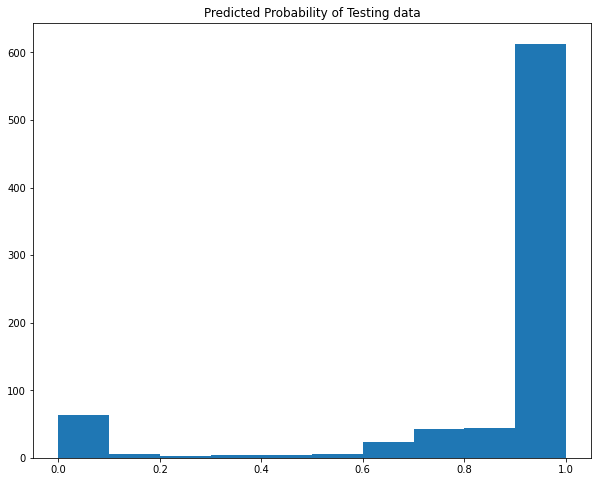

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_test[:,0])
ax.set_title('Predicted Probability of Testing data')

In [34]:
yhat_probs_test = model.predict(x_test.astype('float32'))

26/26 [==============================] - 147s 6s/step


In [35]:
yhat_probs_test_pos=yhat_probs_test[:len(directory_filenames_test_pos)]
yhat_probs_test_neg=yhat_probs_test[len(directory_filenames_test_pos):]
print(len(yhat_probs_test_pos), len(yhat_probs_test_neg))

731 78


Text(0.5, 1.0, 'Predicted Probability of Positive Testing data')

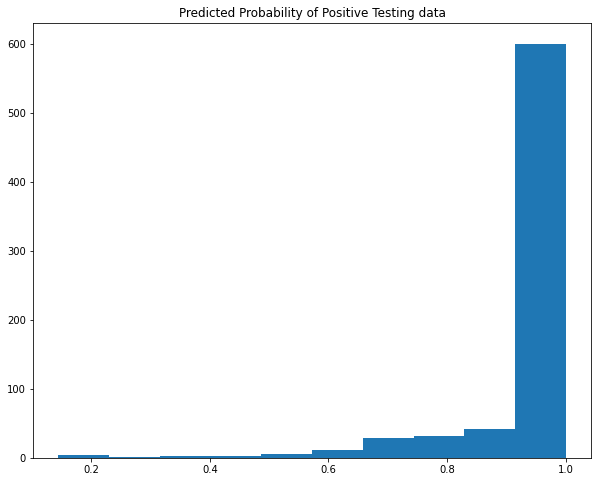

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_test_pos[:,0])
ax.set_title('Predicted Probability of Positive Testing data')

Text(0.5, 1.0, 'Predicted Probability of Negative Testing data')

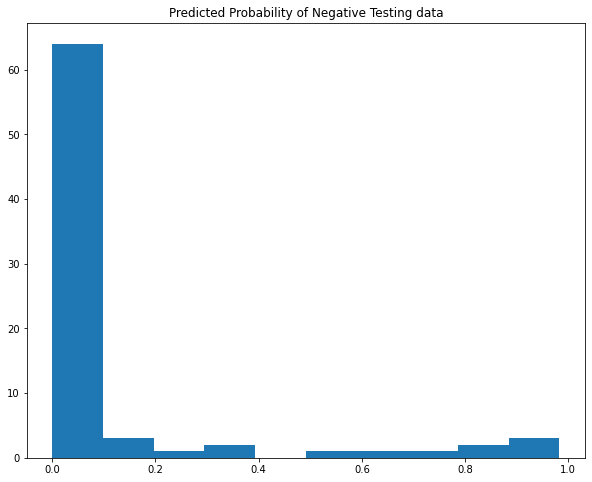

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_test_neg[:,0])
ax.set_title('Predicted Probability of Negative Testing data')

In [38]:
tp=len([i for i in yhat_probs_test_pos if i>=0.5])
fn=len([i for i in yhat_probs_test_pos if i<0.5])
tn=len([i for i in yhat_probs_test_neg if i<0.5])
fp=len([i for i in yhat_probs_test_neg if i>=0.5])
print(tp, fn, tn, fp)
false_negative_rate = fn / (tp + fn)
false_positive_rate = fp / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fp + tn + fn)
print('False Negative Rate:', '{:.2%}'.format(false_negative_rate))
print('False Positive Rate:', '{:.2%}'.format(false_positive_rate))

AUC = roc_auc_score(y_test, yhat_probs_test) 
print('AUC: %.4f' % AUC)
print('Accuracy: %.4f' % accuracy)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)

720 11 70 8
False Negative Rate: 1.50%
False Positive Rate: 10.26%
AUC: 0.9866
Accuracy: 0.9765
Precision: 0.9890
Recall: 0.9850


No handles with labels found to put in legend.


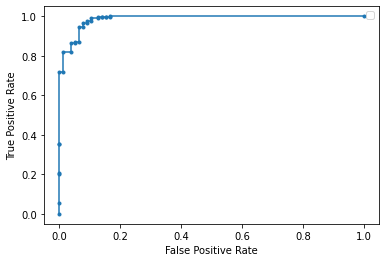

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, yhat_probs_test)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


No handles with labels found to put in legend.


Precesion Recall AUC: 0.9984


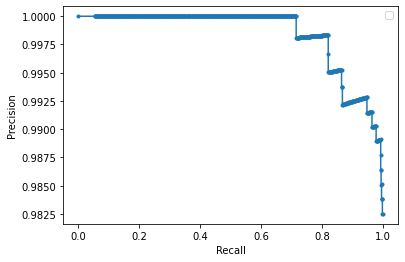

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test, yhat_probs_test)
precision_recall_auc = auc(recall, precision)
print('Precesion Recall AUC: %.4f' % precision_recall_auc)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [41]:
output_positive_test = pd.DataFrame()
output_positive_test['path']=directory_filenames_test_pos
output_positive_test['pred']=yhat_probs_test_pos

Take a look at some false negative and false positive plots

streaming-orcasound-net_2019_11_14_13_26_00_7_pos.png


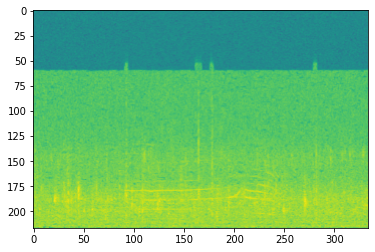

streaming-orcasound-net_2019_11_14_13_58_00_36_pos.png


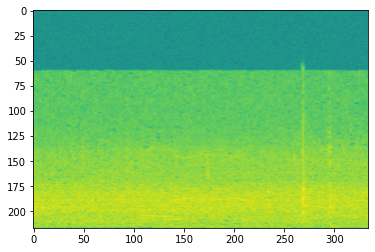

streaming-orcasound-net_2019_11_14_13_57_00_51_pos.png


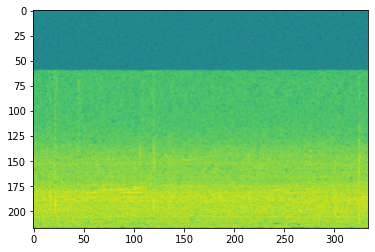

In [42]:
fnsample=output_positive_test.sort_values(by='pred', ascending=True).head(3)
for f in fnsample.path:
    print(f.split('/')[-1])
    img = mpimg.imread(f)
    imgplot = plt.imshow(img)
    plt.show()
del(f, img, imgplot)

In [47]:
output_negative_test = pd.DataFrame()
output_negative_test['path']=directory_filenames_test_neg
output_negative_test['pred']=yhat_probs_test_neg
output_negative_test_fp=output_negative_test[output_negative_test.pred>=0.5]

OS_9_27_2017_11_32_00__0002_0_neg.png


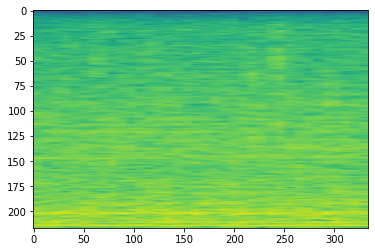

OS_9_27_2017_11_42_00__0000_0_neg.png


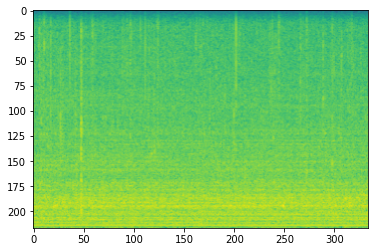

OS_9_27_2017_11_00_00__0004_0_neg.png


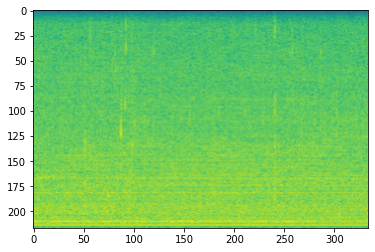

In [48]:
fpsample=output_negative_test.sort_values(by='pred', ascending=False).head(3)
for f in fpsample.path:
    print(f.split('/')[-1])
    img = mpimg.imread(f)
    imgplot = plt.imshow(img)
    plt.show()
del(f, img, imgplot)